In [304]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#import all import libraries
import torch
import torchvision
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms
from torchvision import datasets
from torch import optim
from torch.nn import Sequential
from torchvision.datasets import ImageFolder
from collections import OrderedDict
from torch import nn
import warnings
import cv2
from torch.autograd import Variable
from torchvision import models
import time
from PIL import Image
warnings.filterwarnings("ignore")
%matplotlib inline

In [0]:
#create a transformer
transformer = transforms.Compose([transforms.Resize((256,256)),
                                  transforms.ToTensor(),
                                  transforms.Normalize((.2,),(0.3,))])

In [0]:
path = '/content/drive/My Drive/'

In [0]:
train_data = ImageFolder(path+'/DeepLearning/Data/covid_data/train', transform=transformer)

In [0]:
test_data = ImageFolder(path+'/DeepLearning/Data/covid_data/test',transform=transformer)

In [310]:
train_data.class_to_idx

{'covid': 0, 'normal': 1, 'pneumonia': 2}

In [0]:
#create a function to visualize the dataset
def img_show(images,normalize):
  sb.set_style("whitegrid")
  fig,index = plt.subplots(figsize=(15,10),ncols=5)
  if normalize:
    for i in range(5):
      image = images[i][0]
      image = image.numpy().transpose(1,2,0)
      std = 0.3
      mean = 0.2
      image = std*image + mean
      image = image.squeeze()
      index[i].set_xlabel([])
      index[i].set_ylabel([])
      plt.gray()
      index[i].grid(False)
      index[i].imshow(image)

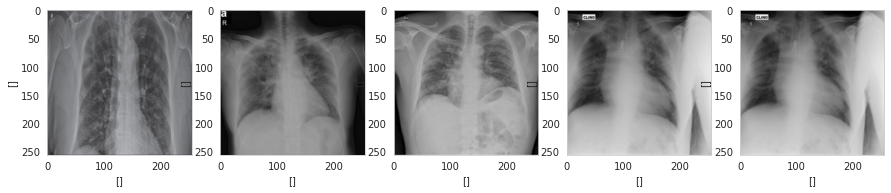

In [312]:
img_show(images=train_data,normalize=True)

In [0]:
#create the dataloaders 
trainloader = DataLoader(train_data,shuffle=True,batch_size=32,num_workers=5)
testloader = DataLoader(test_data,shuffle=True,batch_size=32,num_workers=5)

In [314]:
model = models.resnet18(pretrained=False)
model 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs,3)

In [0]:
dataiter = iter(trainloader)
images,labels = next(dataiter)

In [317]:
images.shape

torch.Size([32, 3, 256, 256])

In [318]:
labels.shape

torch.Size([32])

In [0]:
#create  a criterion 
criterion = nn.NLLLoss()

In [0]:
#create an optimizer and learning rate updater
optimizer = optim.Adam(model.parameters(),lr=0.001,weight_decay=0.01)
lr_sched = optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.01)

In [0]:
#create a function to train and test the model
def training(model,optimizer,criterion,lr_sched,num_epoch):
  since = time.time()
  train_losses = []
  test_losses = []
  train_accuracies = []
  test_accuracies = []
  for epoch in range(num_epoch):
    train_loss = 0 
    train_accuracy = 0
    for images, labels in trainloader:
      log_ps = model(images)
      optimizer.zero_grad()
      loss = criterion(log_ps,labels)
      proba = torch.exp(log_ps)
      topk_index,topk_classes = proba.topk(1,dim=1)
      equals = topk_classes == labels.view(topk_classes.shape)
      train_accuracy += torch.mean(equals.float()) 
      loss.backward()
      optimizer.step()
      train_loss += loss.item()
    else:
        model.eval()
        with torch.no_grad():
          test_loss = 0
          test_accuracy = 0
          for images, labels in testloader:
            log_ps = model(images)
            loss = criterion(log_ps,labels)
            proba = torch.exp(log_ps)
            topk_index,topk_classes = proba.topk(1,dim=1)
            equals = topk_classes == labels.view(topk_classes.shape)
            test_accuracy += torch.mean(equals.float()) 
            test_loss += loss.item() 
    model.train()
    train_losses.append(train_loss/len(trainloader))
    train_accuracies.append(train_accuracy/len(trainloader))
    test_losses.append(test_loss/len(testloader))
    test_accuracies.append(test_accuracy/len(testloader))
    lr_sched.step()
    if epoch%10==0:
        print('--'*10)        
        print("Epoch number is : {}/{} : ".format(epoch+1,num_epoch))
        print('-'*10)
        print("Model training loss : {:.5f} ".format(train_losses[-1]),end=" | ")
        print("Model  validation loss : {:.5f} ".format(test_losses[-1]),end=" | ")
        print("Model accuracy : {:.5f} ".format(test_accuracies[-1]))
  time_elapse = time.time() - since 
  print("Time taken for training : {:.0f}m : {:.0f}s : ".format(time_elapse//60,time_elapse%60))
  best_parameters = model.state_dict()
  torch.save(model.state_dict(), path+'/DeepLearning/covid19_model/covid19_model_params.pth')
  torch.save(model,path+'/DeepLearning/covid19_model/covid19_model.pth')
  return  model,best_parameters,train_losses,test_losses,train_accuracies,test_accuracies

In [322]:
model,best_params,train_losses,test_losses,train_accuracies,test_accuracies = training(model=model,
                                                                                       optimizer=optimizer,
                                                                                       criterion=criterion,
                                                                                       lr_sched=lr_sched,
                                                                                       num_epoch=50)

--------------------
Epoch number is : 1/50 : 
----------
Model training loss : -5.91279  | Model  validation loss : -61.49548  | Model accuracy : 0.22758 
--------------------
Epoch number is : 11/50 : 
----------
Model training loss : -85.08034  | Model  validation loss : -81.62626  | Model accuracy : 0.94090 
--------------------
Epoch number is : 21/50 : 
----------
Model training loss : -87.40033  | Model  validation loss : -87.64177  | Model accuracy : 0.96875 
--------------------
Epoch number is : 31/50 : 
----------
Model training loss : -88.17066  | Model  validation loss : -87.62174  | Model accuracy : 0.96264 
--------------------
Epoch number is : 41/50 : 
----------
Model training loss : -86.98426  | Model  validation loss : -87.97276  | Model accuracy : 0.95652 
Time taken for training : 52m : 0s : 


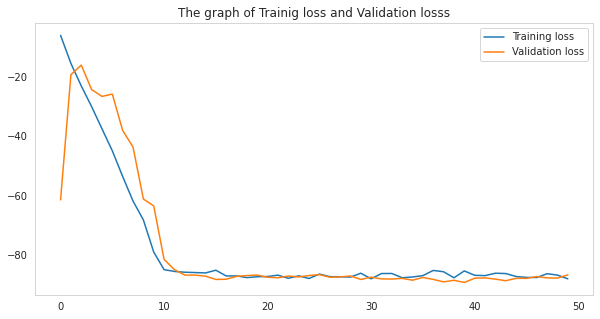

In [323]:
sb.set_style("whitegrid")
plt.figure(figsize=(10,5))
plt.title("The graph of Trainig loss and Validation losss")
plt.plot(train_losses,label="Training loss")
plt.plot(test_losses,label="Validation loss")
plt.grid(False)
plt.legend()
plt.show()

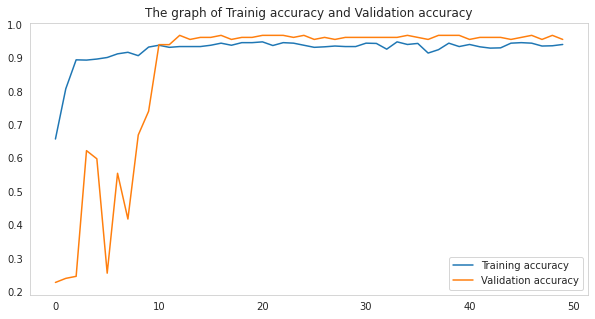

In [324]:
sb.set_style("whitegrid")
plt.figure(figsize=(10,5))
plt.title("The graph of Trainig accuracy and Validation accuracy")
plt.plot(train_accuracies,label="Training accuracy")
plt.plot(test_accuracies,label="Validation accuracy")
plt.grid(False)
plt.legend()
plt.show()

In [0]:
model.eval()
images,labels = next(iter(testloader))
actual_label = labels[16]
predicted_label = model(images[16].view(1,3,256,256))
label_proba = torch.exp(predicted_label)

In [326]:
label_proba.shape

torch.Size([1, 3])

In [0]:
topk_class,topk_idx = label_proba.topk(1,dim=1)

In [328]:
print("Predicted class : ",topk_idx.item(),end=" | ")
print("Actual class : ",actual_label.item())

Predicted class :  1 | Actual class :  1


In [0]:
#load a photo from file
#image = ImageFolder(path+'/DeepLearning/Data/covid_data/',transform=transformer_input)

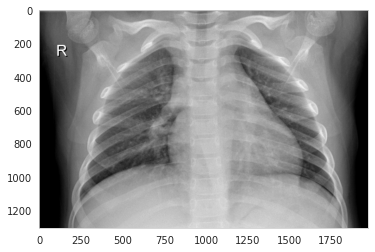

In [334]:
#Visualize the image loaded
sb.set_style("whitegrid")
image = Image.open(path+'/DeepLearning/Data/covid_data/normal0.jpg') # reads image 'test-normal0.jpg' as grayscale
plt.grid(False)
plt.imshow(image, cmap='gray')


In [0]:
#create a dataset transformer
transformer_input = transforms.Compose(transforms=[
                                                  
                                             transforms.Grayscale(num_output_channels=3),
                                             transforms.Resize((256,256)),
                                             transforms.ToTensor(),
                                             transforms.Normalize((0.3,),(0.2,))])

In [0]:

def image_loader(image_name):
    """load image, returns tensor"""
    image = Image.open(image_name)
    image = transformer_input(image).float()
    image = Variable(image, requires_grad=True)
    return image 


In [0]:
image = image_loader(path+'/DeepLearning/Data/covid_data/normal0.jpg')

In [339]:
#load the saved model
loaded_model = models.resnet18()
num_ftrs = loaded_model.fc.in_features
loaded_model.fc = nn.Linear(num_ftrs,3)
loaded_model = torch.load(path+'/DeepLearning/covid19_model/covid19_model.pth',map_location='cpu')
loaded_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
output_single = loaded_model(image.view(1,3,256,256))

In [0]:
output_single_proba = torch.exp(output_single)

In [342]:
output_single_proba

tensor([[3.2303e+09, 8.0417e+27, 4.1009e+16]], grad_fn=<ExpBackward>)

In [0]:
output_sigle_proba_array = output_single_proba.detach().numpy().ravel()

In [0]:
proba_user,predict_single = output_single_proba.topk(1,dim=1)

In [345]:
predict_single

tensor([[1]])

In [0]:
#labels dictionary
labels_dict = {'covid': 0, 'normal': 1, 'pneumonia': 2}

In [348]:
for class_name, class_code in labels_dict.items():  # for name, age in dictionary.iteritems():  (for Python 2.x)
    if class_code == predict_single.item():
        print("The image provided is of ",class_name," class")

The image provided is of  normal  class
